In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/Samin1362/CSE499-MerakiNexus-AI_And_Defi.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Cloning into 'CSE499-MerakiNexus-AI_And_Defi'...
remote: Enumerating objects: 10103, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 10103 (delta 0), reused 2 (delta 0), pack-reused 10097 (from 1)
Receiving objects: 100% (10103/10103), 1.92 GiB | 29.78 MiB/s, done.
Resolving deltas: 100% (1459/1459), done.
Updating files: 100% (8654/8654), done.


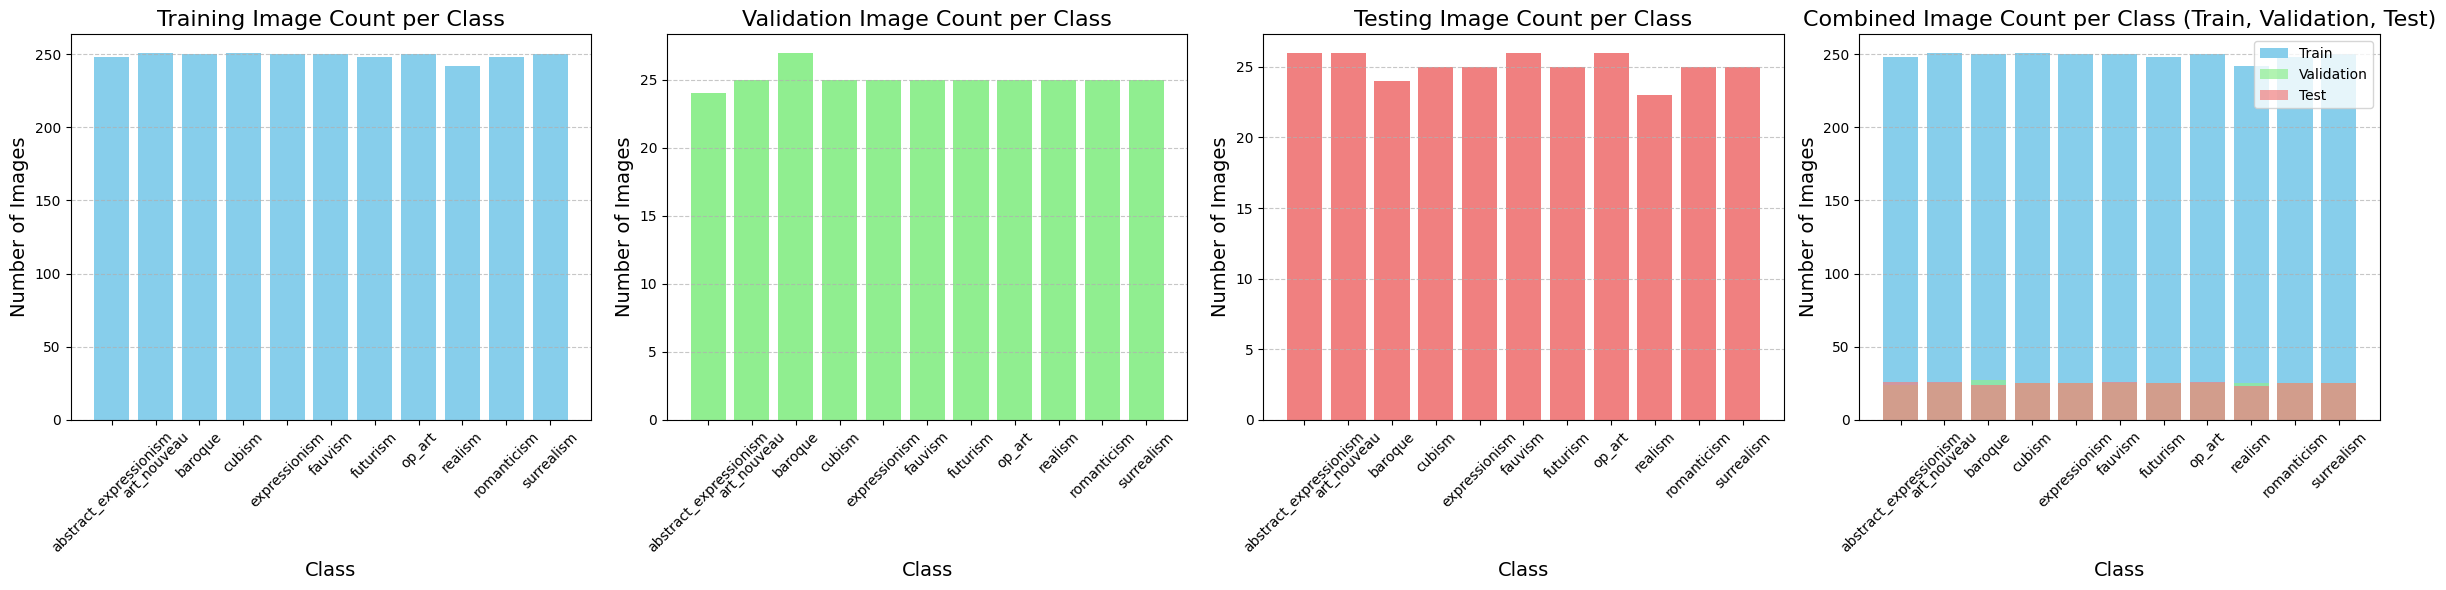

In [4]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/sentiment_model/sentiment_dataset"  # Modify with your dataset path

# Load the datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and their corresponding folder paths
class_names = train_dataset.classes
train_image_counts = []
val_image_counts = []
test_image_counts = []

# Count the number of images in each class folder for all datasets
for class_name in class_names:
    # Count for training set
    train_class_folder = os.path.join(train_dataset.root, class_name)
    train_image_count = len(os.listdir(train_class_folder))  # Count files in each class folder
    train_image_counts.append(train_image_count)

    # Count for validation set
    val_class_folder = os.path.join(val_dataset.root, class_name)
    val_image_count = len(os.listdir(val_class_folder))  # Count files in each class folder
    val_image_counts.append(val_image_count)

    # Count for testing set
    test_class_folder = os.path.join(test_dataset.root, class_name)
    test_image_count = len(os.listdir(test_class_folder))  # Count files in each class folder
    test_image_counts.append(test_image_count)

# Plotting the class distribution for training, validation, and testing sets side by side
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot for training dataset
axes[0].bar(class_names, train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
axes[0].set_xlabel('Class', fontsize=14)
axes[0].set_ylabel('Number of Images', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for validation dataset
axes[1].bar(class_names, val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
axes[1].set_xlabel('Class', fontsize=14)
axes[1].set_ylabel('Number of Images', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for testing dataset
axes[2].bar(class_names, test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
axes[2].set_xlabel('Class', fontsize=14)
axes[2].set_ylabel('Number of Images', fontsize=14)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for combined view (Training, Validation, and Testing)
axes[3].bar(class_names, train_image_counts, color='skyblue', label='Train')
axes[3].bar(class_names, val_image_counts, color='lightgreen', label='Validation', alpha=0.7)
axes[3].bar(class_names, test_image_counts, color='lightcoral', label='Test', alpha=0.7)
axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xlabel('Class', fontsize=14)
axes[3].set_ylabel('Number of Images', fontsize=14)
axes[3].tick_params(axis='x', rotation=45)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

# Mapping of art styles (classes) to sentiment categories (binary labels)
class_to_main_class = {
    "fauvism": [1, 0, 0, 0],               # Emotion Through Color
    "expressionism": [1, 0, 0, 0],
    "abstract_expressionism": [1, 0, 0, 0],

    "cubism": [0, 1, 0, 0],                # Visual Complexity
    "surrealism": [0, 1, 0, 0],
    "op_art": [0, 1, 0, 0],

    "futurism": [0, 0, 1, 0],              # Movement and Flow
    "baroque": [0, 0, 1, 0],
    "art_nouveau": [0, 0, 1, 0],

    "realism": [0, 0, 0, 1],               # Facial Expressions and Human Emotion
    "romanticism": [0, 0, 0, 1]
}

# Custom dataset class for sentiment model
class CustomSentimentDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super().__init__(root_dir, transform=transform)
        self.class_to_main_class = class_to_main_class

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.class_to_main_class[self.classes[class_idx]], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to dataset (modify to your local directory)
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/sentiment_model/sentiment_dataset"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load datasets
train_data = CustomSentimentDataset(root_dir=f"{dataset_path}/train", transform=transform)
val_data = CustomSentimentDataset(root_dir=f"{dataset_path}/val", transform=transform)
test_data = CustomSentimentDataset(root_dir=f"{dataset_path}/test", transform=transform)

# Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]
Epoch 1/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.78batch/s, loss=1.41]


Epoch 1/25 completed in 48.40 seconds.
Epoch Loss: 1.3807963909104812
Train Accuracy: 84.80%


Epoch 1/25 Validation Accuracy: 84.15%


Epoch 2/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.79batch/s, loss=0.69]


Epoch 2/25 completed in 48.06 seconds.
Epoch Loss: 0.5906839103892793
Train Accuracy: 94.48%


Epoch 2/25 Validation Accuracy: 82.34%


Epoch 3/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.78batch/s, loss=0.593]


Epoch 3/25 completed in 48.42 seconds.
Epoch Loss: 0.2907202410143475
Train Accuracy: 97.50%


Epoch 3/25 Validation Accuracy: 88.32%


Epoch 4/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.79batch/s, loss=0.162]


Epoch 4/25 completed in 48.14 seconds.
Epoch Loss: 0.27357835799109104
Train Accuracy: 97.44%


Epoch 4/25 Validation Accuracy: 87.05%


Epoch 5/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.76batch/s, loss=0.16]


Epoch 5/25 completed in 48.98 seconds.
Epoch Loss: 0.1786646610992246
Train Accuracy: 98.49%


Epoch 5/25 Validation Accuracy: 86.87%


Epoch 6/25 Training: 100%|██████████| 86/86 [00:47<00:00,  1.80batch/s, loss=0.121]


Epoch 6/25 completed in 47.81 seconds.
Epoch Loss: 0.1225259724982776
Train Accuracy: 98.92%


Epoch 6/25 Validation Accuracy: 86.87%


Epoch 7/25 Training: 100%|██████████| 86/86 [00:47<00:00,  1.80batch/s, loss=0.322]


Epoch 7/25 completed in 47.90 seconds.
Epoch Loss: 0.12658417954239562
Train Accuracy: 98.94%


Epoch 7/25 Validation Accuracy: 86.96%


Epoch 8/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.78batch/s, loss=0.026]


Epoch 8/25 completed in 48.29 seconds.
Epoch Loss: 0.0865800780417441
Train Accuracy: 99.31%


Epoch 8/25 Validation Accuracy: 86.50%


Epoch 9/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.79batch/s, loss=0.0499]


Epoch 9/25 completed in 48.18 seconds.
Epoch Loss: 0.09797701254205475
Train Accuracy: 99.17%


Epoch 9/25 Validation Accuracy: 86.68%


Epoch 10/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.77batch/s, loss=0.154]


Epoch 10/25 completed in 48.70 seconds.
Epoch Loss: 0.13598864308428452
Train Accuracy: 98.77%


Epoch 10/25 Validation Accuracy: 84.24%


Epoch 11/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.77batch/s, loss=0.00429]


Epoch 11/25 completed in 48.46 seconds.
Epoch Loss: 0.0632019701662885
Train Accuracy: 99.56%


Epoch 11/25 Validation Accuracy: 89.76%


Epoch 12/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.79batch/s, loss=0.0114]


Epoch 12/25 completed in 48.04 seconds.
Epoch Loss: 0.06588189534269014
Train Accuracy: 99.31%


Epoch 12/25 Validation Accuracy: 86.50%


Epoch 13/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.78batch/s, loss=0.0304]


Epoch 13/25 completed in 48.25 seconds.
Epoch Loss: 0.10518602962432386
Train Accuracy: 99.04%


Epoch 13/25 Validation Accuracy: 87.95%


Epoch 14/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.78batch/s, loss=0.865]


Epoch 14/25 completed in 48.21 seconds.
Epoch Loss: 0.14861469295114105
Train Accuracy: 98.66%


Epoch 14/25 Validation Accuracy: 88.13%


Epoch 15/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.79batch/s, loss=0.0928]


Epoch 15/25 completed in 48.04 seconds.
Epoch Loss: 0.13464693659050173
Train Accuracy: 99.03%


Epoch 15/25 Validation Accuracy: 88.59%


Epoch 16/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.78batch/s, loss=0.621]


Epoch 16/25 completed in 48.44 seconds.
Epoch Loss: 0.07648641734145754
Train Accuracy: 99.38%


Epoch 16/25 Validation Accuracy: 87.86%


Epoch 17/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.77batch/s, loss=2.42]


Epoch 17/25 completed in 48.64 seconds.
Epoch Loss: 0.10596899394362862
Train Accuracy: 99.33%


Epoch 17/25 Validation Accuracy: 86.68%


Epoch 18/25 Training: 100%|██████████| 86/86 [00:47<00:00,  1.80batch/s, loss=0.0136]


Epoch 18/25 completed in 47.89 seconds.
Epoch Loss: 0.10481170744927557
Train Accuracy: 99.19%


Epoch 18/25 Validation Accuracy: 87.95%


Epoch 19/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.79batch/s, loss=0.0103]


Epoch 19/25 completed in 48.17 seconds.
Epoch Loss: 0.0229926717841218
Train Accuracy: 99.84%


Epoch 19/25 Validation Accuracy: 87.95%


Epoch 20/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.78batch/s, loss=0.0168]


Epoch 20/25 completed in 48.27 seconds.
Epoch Loss: 0.01174006539838237
Train Accuracy: 99.94%


Epoch 20/25 Validation Accuracy: 89.04%


Epoch 21/25 Training: 100%|██████████| 86/86 [00:47<00:00,  1.81batch/s, loss=0.0381]


Epoch 21/25 completed in 47.65 seconds.
Epoch Loss: 0.0053072966449774885
Train Accuracy: 99.99%


Epoch 21/25 Validation Accuracy: 89.22%


Epoch 22/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.79batch/s, loss=0.00438]


Epoch 22/25 completed in 48.10 seconds.
Epoch Loss: 0.022909769591425957
Train Accuracy: 99.72%


Epoch 22/25 Validation Accuracy: 87.86%


Epoch 23/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.78batch/s, loss=0.129]


Epoch 23/25 completed in 48.36 seconds.
Epoch Loss: 0.03918223696500929
Train Accuracy: 99.70%


Epoch 23/25 Validation Accuracy: 86.78%


Epoch 24/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.79batch/s, loss=0.0175]


Epoch 24/25 completed in 48.16 seconds.
Epoch Loss: 0.031071172038981215
Train Accuracy: 99.74%


Epoch 24/25 Validation Accuracy: 88.04%


Epoch 25/25 Training: 100%|██████████| 86/86 [00:48<00:00,  1.78batch/s, loss=0.00889]


Epoch 25/25 completed in 48.34 seconds.
Epoch Loss: 0.07299547495055121
Train Accuracy: 99.41%


Epoch 25/25 Validation Accuracy: 88.04%

Total Training Time: 1253.86 seconds (20.90 minutes)


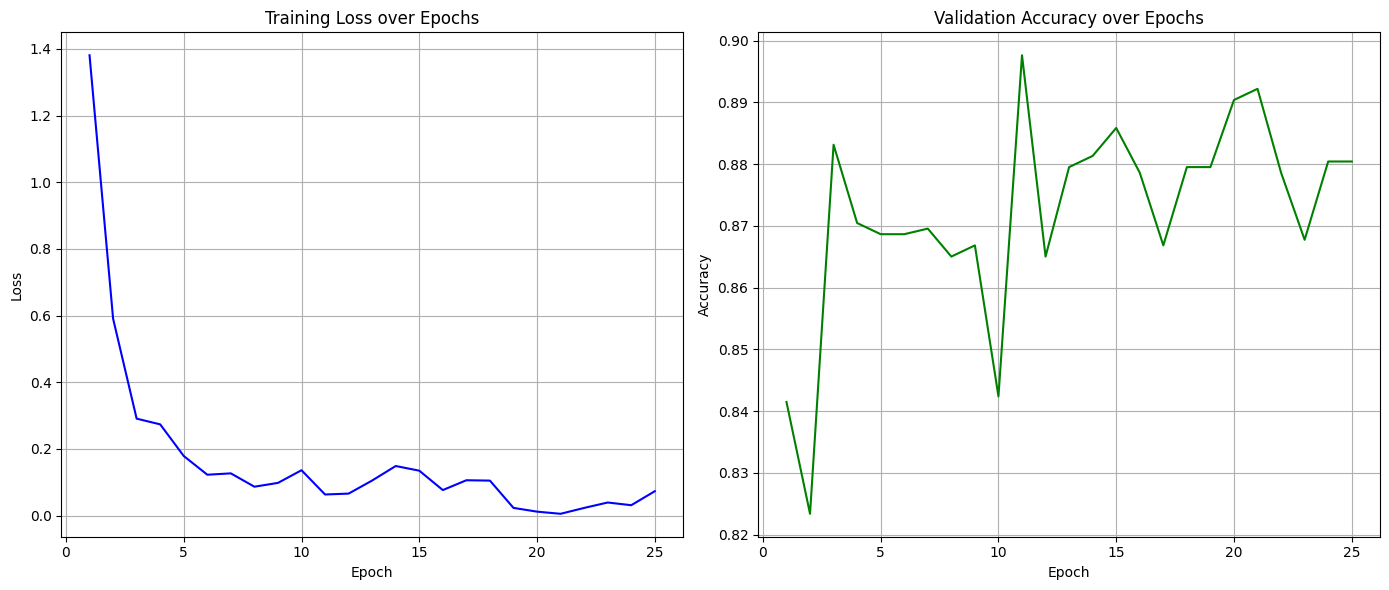

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define sentiment categories
sentiment_categories = ["Emotion Through Color", "Visual Complexity", "Movement and Flow", "Facial Expressions and Human Emotion"]

# Define model based on ResNet50 with custom heads for the 4 sentiment classes
class SentimentModelWithResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(SentimentModelWithResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Get the in_features from ResNet50's final fully connected layer
        in_features = self.resnet.fc.in_features

        # Remove the final fully connected layer (so that we can add custom heads)
        self.resnet.fc = nn.Identity()

        # Custom heads for the 4 sentiment classes
        self.emotion_color_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Emotion Through Color
        )

        self.visual_complexity_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Visual Complexity
        )

        self.movement_flow_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Movement and Flow
        )

        self.human_emotion_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Facial Expressions and Human Emotion
        )

    def forward(self, x):
        features = self.resnet(x)
        emotion_color = self.emotion_color_head(features)
        visual_complexity = self.visual_complexity_head(features)
        movement_flow = self.movement_flow_head(features)
        human_emotion = self.human_emotion_head(features)
        return emotion_color, visual_complexity, movement_flow, human_emotion

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNet50_model = SentimentModelWithResNet50(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resNet50_model.parameters(), lr=1e-4)

# Training setup
num_epochs = 25
start_time = time.time()
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    resNet50_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            emotion_color, visual_complexity, movement_flow, human_emotion = resNet50_model(images)

            loss1 = criterion(emotion_color.squeeze(), labels[:, 0])
            loss2 = criterion(visual_complexity.squeeze(), labels[:, 1])
            loss3 = criterion(movement_flow.squeeze(), labels[:, 2])
            loss4 = criterion(human_emotion.squeeze(), labels[:, 3])

            total_loss = loss1 + loss2 + loss3 + loss4
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            predictions = torch.cat([
                torch.sigmoid(emotion_color),
                torch.sigmoid(visual_complexity),
                torch.sigmoid(movement_flow),
                torch.sigmoid(human_emotion)
            ], dim=1)

            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)

            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")

    train_accuracy = correct_train / total_train if total_train > 0 else 0
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    resNet50_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            emotion_color, visual_complexity, movement_flow, human_emotion = resNet50_model(images)

            pred1 = torch.sigmoid(emotion_color)
            pred2 = torch.sigmoid(visual_complexity)
            pred3 = torch.sigmoid(movement_flow)
            pred4 = torch.sigmoid(human_emotion)

            correct_val += (pred1 > 0.5).float().eq(labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (pred2 > 0.5).float().eq(labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (pred3 > 0.5).float().eq(labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (pred4 > 0.5).float().eq(labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4

    val_accuracy = correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Total training time
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Plotting Loss and Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


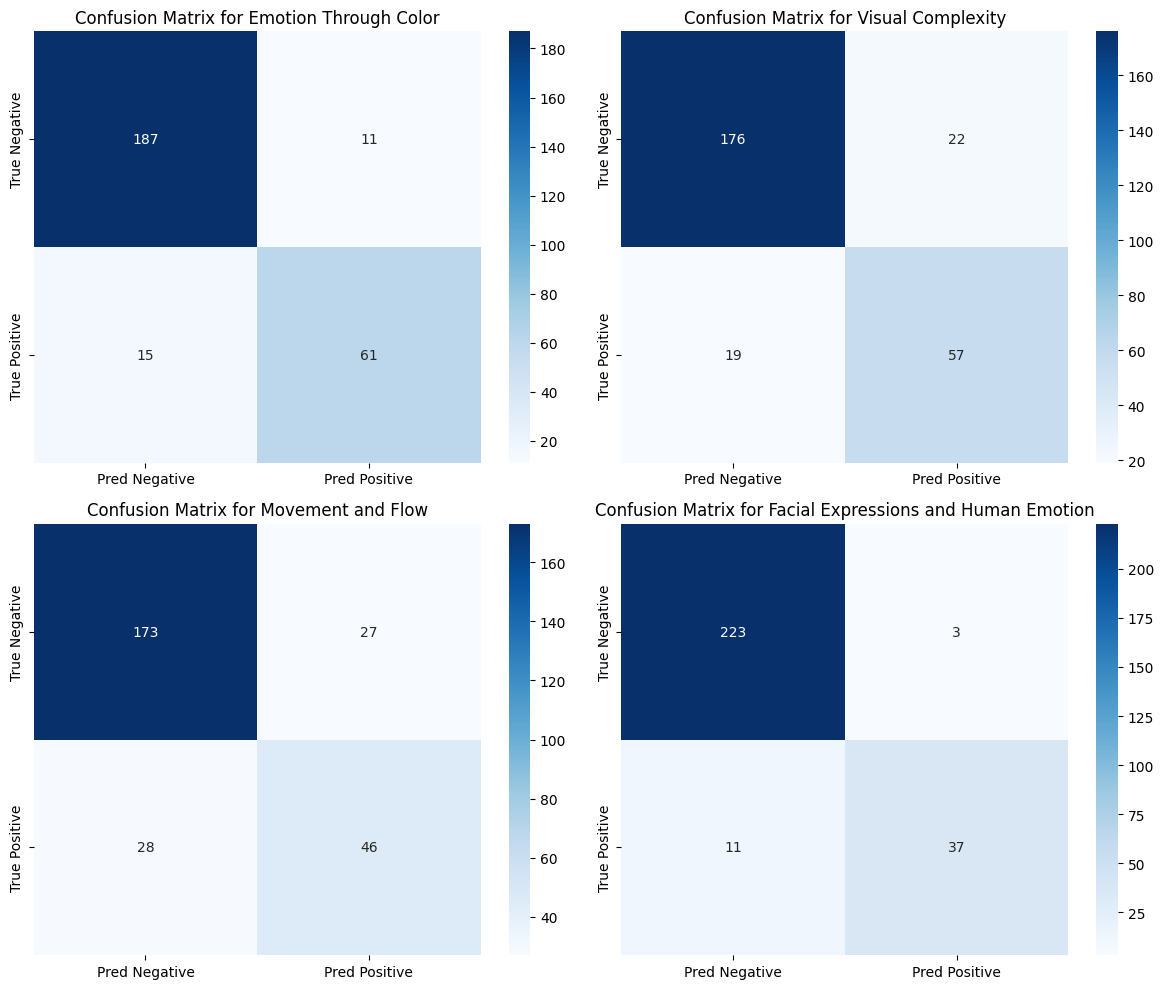

Test Accuracy: 87.59%
Precision: 72.63%
Recall: 73.36%
F1-Score: 72.87%


In [ ]:
# Define sentiment categories
sentiment_categories = ["Emotion Through Color", "Visual Complexity", "Movement and Flow", "Facial Expressions and Human Emotion"]

# Set the model to evaluation mode
resNet50_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        emotion_color, visual_complexity, movement_flow, human_emotion = resNet50_model(images)

        # Convert logits to probabilities using sigmoid
        pred_emotion_color = torch.sigmoid(emotion_color)
        pred_visual_complexity = torch.sigmoid(visual_complexity)
        pred_movement_flow = torch.sigmoid(movement_flow)
        pred_human_emotion = torch.sigmoid(human_emotion)

        # Binarize predictions (thresholding at 0.5)
        bin_emotion_color = (pred_emotion_color > 0.5).float()
        bin_visual_complexity = (pred_visual_complexity > 0.5).float()
        bin_movement_flow = (pred_movement_flow > 0.5).float()
        bin_human_emotion = (pred_human_emotion > 0.5).float()

        # Concatenate predictions for multi-label output
        batch_preds = torch.cat([bin_emotion_color, bin_visual_complexity, bin_movement_flow, bin_human_emotion], dim=1)
        all_predictions.append(batch_preds)
        all_labels.append(labels)

# Convert to NumPy arrays
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Compute evaluation metrics
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Multi-label confusion matrices
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'],
                ax=ax)
    ax.set_title(f'Confusion Matrix for {sentiment_categories[i]}')

plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 135MB/s]
Epoch 1/25 Training: 100%|██████████| 86/86 [01:05<00:00,  1.31batch/s, loss=1.47]


Epoch 1/25 completed in 65.65 seconds.
Epoch Loss: 1.3450876314972722
Train Accuracy: 84.39%


Epoch 1/25 Validation Accuracy: 84.51%


Epoch 2/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.234]


Epoch 2/25 completed in 64.69 seconds.
Epoch Loss: 0.6334449576084004
Train Accuracy: 94.01%


Epoch 2/25 Validation Accuracy: 88.50%


Epoch 3/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.325]


Epoch 3/25 completed in 64.58 seconds.
Epoch Loss: 0.35492187374553014
Train Accuracy: 96.84%


Epoch 3/25 Validation Accuracy: 84.87%


Epoch 4/25 Training: 100%|██████████| 86/86 [01:05<00:00,  1.32batch/s, loss=0.175]


Epoch 4/25 completed in 65.08 seconds.
Epoch Loss: 0.30237267421948355
Train Accuracy: 97.00%


Epoch 4/25 Validation Accuracy: 87.86%


Epoch 5/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.0863]


Epoch 5/25 completed in 64.56 seconds.
Epoch Loss: 0.2223406181952288
Train Accuracy: 97.93%


Epoch 5/25 Validation Accuracy: 87.50%


Epoch 6/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.0205]


Epoch 6/25 completed in 64.88 seconds.
Epoch Loss: 0.10291027800764802
Train Accuracy: 99.07%


Epoch 6/25 Validation Accuracy: 86.59%


Epoch 7/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.0777]


Epoch 7/25 completed in 64.79 seconds.
Epoch Loss: 0.088358354413622
Train Accuracy: 99.26%


Epoch 7/25 Validation Accuracy: 85.42%


Epoch 8/25 Training: 100%|██████████| 86/86 [01:05<00:00,  1.31batch/s, loss=2.19]


Epoch 8/25 completed in 65.48 seconds.
Epoch Loss: 0.19334261195171018
Train Accuracy: 98.30%


Epoch 8/25 Validation Accuracy: 87.95%


Epoch 9/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.0324]


Epoch 9/25 completed in 64.58 seconds.
Epoch Loss: 0.1999368955229604
Train Accuracy: 98.30%


Epoch 9/25 Validation Accuracy: 87.23%


Epoch 10/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.116]


Epoch 10/25 completed in 64.57 seconds.
Epoch Loss: 0.13177536845986926
Train Accuracy: 98.96%


Epoch 10/25 Validation Accuracy: 89.13%


Epoch 11/25 Training: 100%|██████████| 86/86 [01:05<00:00,  1.32batch/s, loss=1.13]


Epoch 11/25 completed in 65.05 seconds.
Epoch Loss: 0.09550212612808791
Train Accuracy: 99.16%


Epoch 11/25 Validation Accuracy: 90.13%


Epoch 12/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.137]


Epoch 12/25 completed in 64.85 seconds.
Epoch Loss: 0.10720834531279844
Train Accuracy: 99.10%


Epoch 12/25 Validation Accuracy: 86.68%


Epoch 13/25 Training: 100%|██████████| 86/86 [01:05<00:00,  1.32batch/s, loss=0.0418]


Epoch 13/25 completed in 65.06 seconds.
Epoch Loss: 0.06544509405800857
Train Accuracy: 99.55%


Epoch 13/25 Validation Accuracy: 88.68%


Epoch 14/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.029]


Epoch 14/25 completed in 64.62 seconds.
Epoch Loss: 0.058680302988694505
Train Accuracy: 99.49%


Epoch 14/25 Validation Accuracy: 86.41%


Epoch 15/25 Training: 100%|██████████| 86/86 [01:05<00:00,  1.32batch/s, loss=0.0191]


Epoch 15/25 completed in 65.11 seconds.
Epoch Loss: 0.07983568576326984
Train Accuracy: 99.38%


Epoch 15/25 Validation Accuracy: 88.68%


Epoch 16/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.32batch/s, loss=0.00278]


Epoch 16/25 completed in 64.96 seconds.
Epoch Loss: 0.09181662815687962
Train Accuracy: 99.31%


Epoch 16/25 Validation Accuracy: 90.13%


Epoch 17/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.0152]


Epoch 17/25 completed in 64.68 seconds.
Epoch Loss: 0.07198932150183895
Train Accuracy: 99.38%


Epoch 17/25 Validation Accuracy: 86.68%


Epoch 18/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.0133]


Epoch 18/25 completed in 64.88 seconds.
Epoch Loss: 0.04449306766036898
Train Accuracy: 99.60%


Epoch 18/25 Validation Accuracy: 89.04%


Epoch 19/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.27]


Epoch 19/25 completed in 64.54 seconds.
Epoch Loss: 0.02719790283874825
Train Accuracy: 99.80%


Epoch 19/25 Validation Accuracy: 89.31%


Epoch 20/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.0303]


Epoch 20/25 completed in 64.90 seconds.
Epoch Loss: 0.06664876408636743
Train Accuracy: 99.41%


Epoch 20/25 Validation Accuracy: 87.77%


Epoch 21/25 Training: 100%|██████████| 86/86 [01:05<00:00,  1.32batch/s, loss=0.00459]


Epoch 21/25 completed in 65.31 seconds.
Epoch Loss: 0.04496159385970989
Train Accuracy: 99.63%


Epoch 21/25 Validation Accuracy: 87.41%


Epoch 22/25 Training: 100%|██████████| 86/86 [01:05<00:00,  1.32batch/s, loss=2.6]


Epoch 22/25 completed in 65.10 seconds.
Epoch Loss: 0.12148759834235534
Train Accuracy: 99.21%


Epoch 22/25 Validation Accuracy: 88.32%


Epoch 23/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.166]


Epoch 23/25 completed in 64.53 seconds.
Epoch Loss: 0.10596579217438608
Train Accuracy: 99.14%


Epoch 23/25 Validation Accuracy: 86.96%


Epoch 24/25 Training: 100%|██████████| 86/86 [01:04<00:00,  1.33batch/s, loss=0.00771]


Epoch 24/25 completed in 64.80 seconds.
Epoch Loss: 0.0440527081319001
Train Accuracy: 99.66%


Epoch 24/25 Validation Accuracy: 86.59%


Epoch 25/25 Training: 100%|██████████| 86/86 [01:05<00:00,  1.31batch/s, loss=0.0133]


Epoch 25/25 completed in 65.54 seconds.
Epoch Loss: 0.07734177728335179
Train Accuracy: 99.33%


Epoch 25/25 Validation Accuracy: 85.05%

Total Training Time: 1683.84 seconds (28.06 minutes)


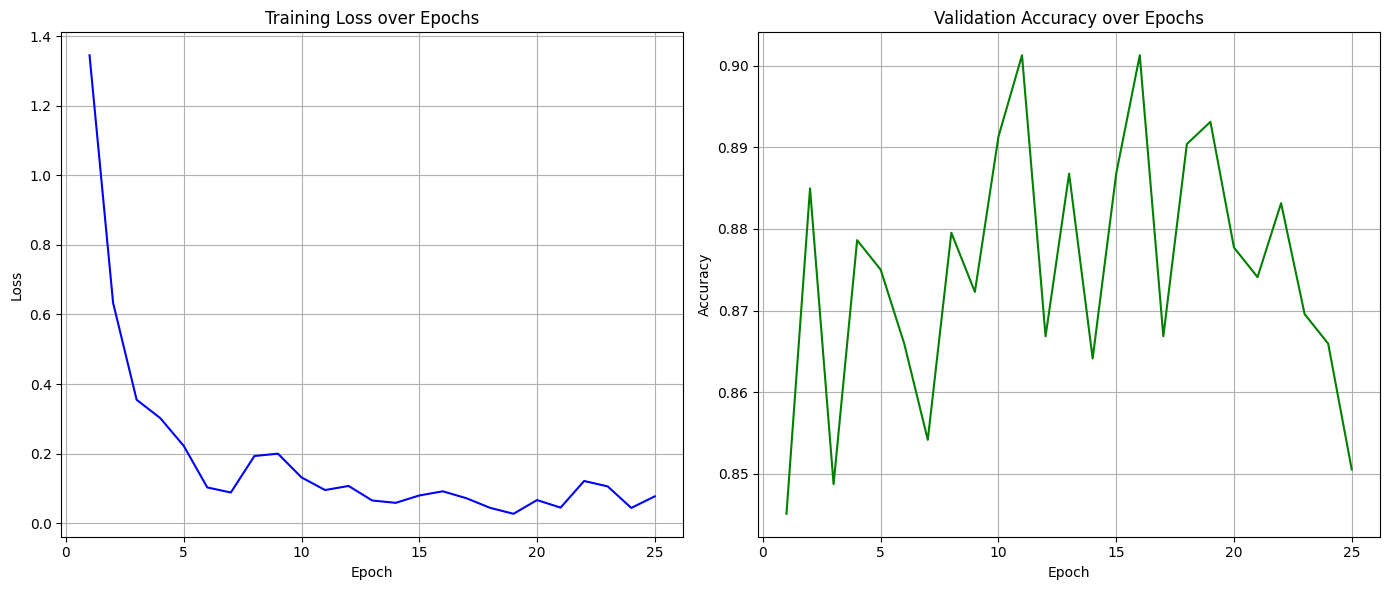

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define sentiment categories
sentiment_categories = ["Emotion Through Color", "Visual Complexity", "Movement and Flow", "Facial Expressions and Human Emotion"]

# Define model based on ResNet101 with custom heads for the 4 sentiment classes
class SentimentModelWithResNet101(nn.Module):
    def __init__(self, num_classes=4):
        super(SentimentModelWithResNet101, self).__init__()
        self.resnet = models.resnet101(pretrained=True)

        # Get the in_features from ResNet101's final fully connected layer
        in_features = self.resnet.fc.in_features

        # Remove the final fully connected layer (so that we can add custom heads)
        self.resnet.fc = nn.Identity()

        # Custom heads for the 4 sentiment classes
        self.emotion_color_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Emotion Through Color
        )

        self.visual_complexity_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Visual Complexity
        )

        self.movement_flow_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Movement and Flow
        )

        self.human_emotion_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Facial Expressions and Human Emotion
        )

    def forward(self, x):
        features = self.resnet(x)
        emotion_color = self.emotion_color_head(features)
        visual_complexity = self.visual_complexity_head(features)
        movement_flow = self.movement_flow_head(features)
        human_emotion = self.human_emotion_head(features)
        return emotion_color, visual_complexity, movement_flow, human_emotion

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNet101_model = SentimentModelWithResNet101(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resNet101_model.parameters(), lr=1e-4)

# Training setup
num_epochs = 25
start_time = time.time()
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    resNet101_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            emotion_color, visual_complexity, movement_flow, human_emotion = resNet101_model(images)

            loss1 = criterion(emotion_color.squeeze(), labels[:, 0])
            loss2 = criterion(visual_complexity.squeeze(), labels[:, 1])
            loss3 = criterion(movement_flow.squeeze(), labels[:, 2])
            loss4 = criterion(human_emotion.squeeze(), labels[:, 3])

            total_loss = loss1 + loss2 + loss3 + loss4
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            predictions = torch.cat([
                torch.sigmoid(emotion_color),
                torch.sigmoid(visual_complexity),
                torch.sigmoid(movement_flow),
                torch.sigmoid(human_emotion)
            ], dim=1)

            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)

            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")

    train_accuracy = correct_train / total_train if total_train > 0 else 0
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    resNet101_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            emotion_color, visual_complexity, movement_flow, human_emotion = resNet101_model(images)

            pred1 = torch.sigmoid(emotion_color)
            pred2 = torch.sigmoid(visual_complexity)
            pred3 = torch.sigmoid(movement_flow)
            pred4 = torch.sigmoid(human_emotion)

            correct_val += (pred1 > 0.5).float().eq(labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (pred2 > 0.5).float().eq(labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (pred3 > 0.5).float().eq(labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (pred4 > 0.5).float().eq(labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4

    val_accuracy = correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Total training time
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Plotting Loss and Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


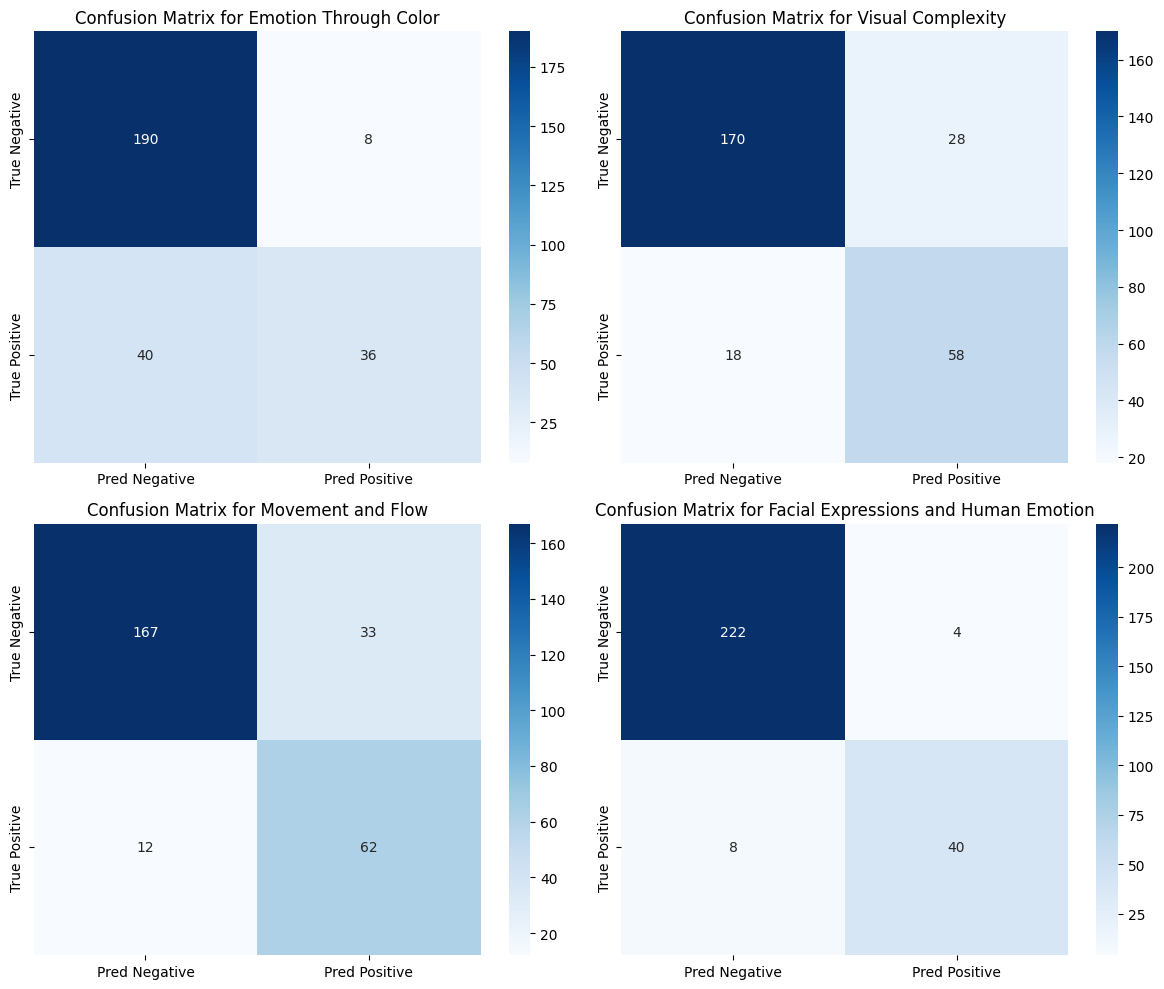

Test Accuracy: 86.22%
Precision: 70.44%
Recall: 71.53%
F1-Score: 70.80%


In [ ]:
# Define sentiment categories
sentiment_categories = ["Emotion Through Color", "Visual Complexity", "Movement and Flow", "Facial Expressions and Human Emotion"]

# Set the model to evaluation mode
resNet101_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        emotion_color, visual_complexity, movement_flow, human_emotion = resNet101_model(images)

        # Convert logits to probabilities using sigmoid
        pred_emotion_color = torch.sigmoid(emotion_color)
        pred_visual_complexity = torch.sigmoid(visual_complexity)
        pred_movement_flow = torch.sigmoid(movement_flow)
        pred_human_emotion = torch.sigmoid(human_emotion)

        # Binarize predictions (thresholding at 0.5)
        bin_emotion_color = (pred_emotion_color > 0.5).float()
        bin_visual_complexity = (pred_visual_complexity > 0.5).float()
        bin_movement_flow = (pred_movement_flow > 0.5).float()
        bin_human_emotion = (pred_human_emotion > 0.5).float()

        # Concatenate predictions for multi-label output
        batch_preds = torch.cat([bin_emotion_color, bin_visual_complexity, bin_movement_flow, bin_human_emotion], dim=1)
        all_predictions.append(batch_preds)
        all_labels.append(labels)

# Convert to NumPy arrays
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Compute evaluation metrics
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Multi-label confusion matrices
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'],
                ax=ax)
    ax.set_title(f'Confusion Matrix for {sentiment_categories[i]}')

plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.27s/batch, loss=1.19]


Epoch 1 completed in 108.99 seconds.
Epoch Loss: 1.8392484784126282
Train Accuracy: 77.72%


Validation Accuracy: 81.34%


Epoch 2/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=1.18]


Epoch 2 completed in 108.41 seconds.
Epoch Loss: 1.314619096212609
Train Accuracy: 84.94%


Validation Accuracy: 80.98%


Epoch 3/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.482]


Epoch 3 completed in 108.35 seconds.
Epoch Loss: 0.9102203450923743
Train Accuracy: 90.22%


Validation Accuracy: 84.87%


Epoch 4/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.562]


Epoch 4 completed in 108.18 seconds.
Epoch Loss: 0.5732184298509775
Train Accuracy: 94.48%


Validation Accuracy: 83.88%


Epoch 5/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.333]


Epoch 5 completed in 108.35 seconds.
Epoch Loss: 0.4186376594223602
Train Accuracy: 96.20%


Validation Accuracy: 82.97%


Epoch 6/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.236]


Epoch 6 completed in 108.40 seconds.
Epoch Loss: 0.3013238204469861
Train Accuracy: 97.04%


Validation Accuracy: 82.88%


Epoch 7/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.27s/batch, loss=0.68]


Epoch 7 completed in 108.86 seconds.
Epoch Loss: 0.18868001970614112
Train Accuracy: 98.16%


Validation Accuracy: 82.07%


Epoch 8/25 Training: 100%|██████████| 86/86 [01:49<00:00,  1.27s/batch, loss=0.101]


Epoch 8 completed in 109.02 seconds.
Epoch Loss: 0.19512378446064715
Train Accuracy: 98.34%


Validation Accuracy: 84.06%


Epoch 9/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.00813]


Epoch 9 completed in 108.60 seconds.
Epoch Loss: 0.12881710969972923
Train Accuracy: 98.92%


Validation Accuracy: 83.15%


Epoch 10/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.135]


Epoch 10 completed in 108.42 seconds.
Epoch Loss: 0.16558317173824666
Train Accuracy: 98.74%


Validation Accuracy: 80.16%


Epoch 11/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.0552]


Epoch 11 completed in 108.38 seconds.
Epoch Loss: 0.16406027633198644
Train Accuracy: 98.58%


Validation Accuracy: 82.88%


Epoch 12/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.759]


Epoch 12 completed in 108.50 seconds.
Epoch Loss: 0.14199273742811191
Train Accuracy: 98.95%


Validation Accuracy: 83.51%


Epoch 13/25 Training: 100%|██████████| 86/86 [01:49<00:00,  1.27s/batch, loss=0.121]


Epoch 13 completed in 109.01 seconds.
Epoch Loss: 0.10364448929443783
Train Accuracy: 99.06%


Validation Accuracy: 84.78%


Epoch 14/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.00449]


Epoch 14 completed in 108.28 seconds.
Epoch Loss: 0.11538384585955375
Train Accuracy: 99.08%


Validation Accuracy: 83.97%


Epoch 15/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.0922]


Epoch 15 completed in 108.27 seconds.
Epoch Loss: 0.08551180126351239
Train Accuracy: 99.27%


Validation Accuracy: 84.15%


Epoch 16/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.0982]


Epoch 16 completed in 108.55 seconds.
Epoch Loss: 0.07696680853760607
Train Accuracy: 99.28%


Validation Accuracy: 80.07%


Epoch 17/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.0448]


Epoch 17 completed in 108.15 seconds.
Epoch Loss: 0.10791100229429038
Train Accuracy: 99.01%


Validation Accuracy: 82.07%


Epoch 18/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.27s/batch, loss=0.0757]


Epoch 18 completed in 108.85 seconds.
Epoch Loss: 0.12514785138164583
Train Accuracy: 98.85%


Validation Accuracy: 83.61%


Epoch 19/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.0223]


Epoch 19 completed in 108.50 seconds.
Epoch Loss: 0.07939189886349406
Train Accuracy: 99.35%


Validation Accuracy: 83.33%


Epoch 20/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.00451]


Epoch 20 completed in 108.49 seconds.
Epoch Loss: 0.046913744190702385
Train Accuracy: 99.66%


Validation Accuracy: 82.25%


Epoch 21/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.0697]


Epoch 21 completed in 108.12 seconds.
Epoch Loss: 0.06421060532028246
Train Accuracy: 99.54%


Validation Accuracy: 81.52%


Epoch 22/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.27s/batch, loss=0.000644]


Epoch 22 completed in 108.90 seconds.
Epoch Loss: 0.010258928009682486
Train Accuracy: 99.91%


Validation Accuracy: 79.71%


Epoch 23/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.00209]


Epoch 23 completed in 108.53 seconds.
Epoch Loss: 0.03581842420342497
Train Accuracy: 99.73%


Validation Accuracy: 79.98%


Epoch 24/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.26s/batch, loss=0.00339]


Epoch 24 completed in 108.15 seconds.
Epoch Loss: 0.1515383432926556
Train Accuracy: 98.62%


Validation Accuracy: 81.88%


Epoch 25/25 Training: 100%|██████████| 86/86 [01:48<00:00,  1.27s/batch, loss=0.0634]


Epoch 25 completed in 109.00 seconds.
Epoch Loss: 0.117289417966805
Train Accuracy: 98.98%


Validation Accuracy: 80.98%

Total Training Time: 2810.45 seconds (46.84 minutes)


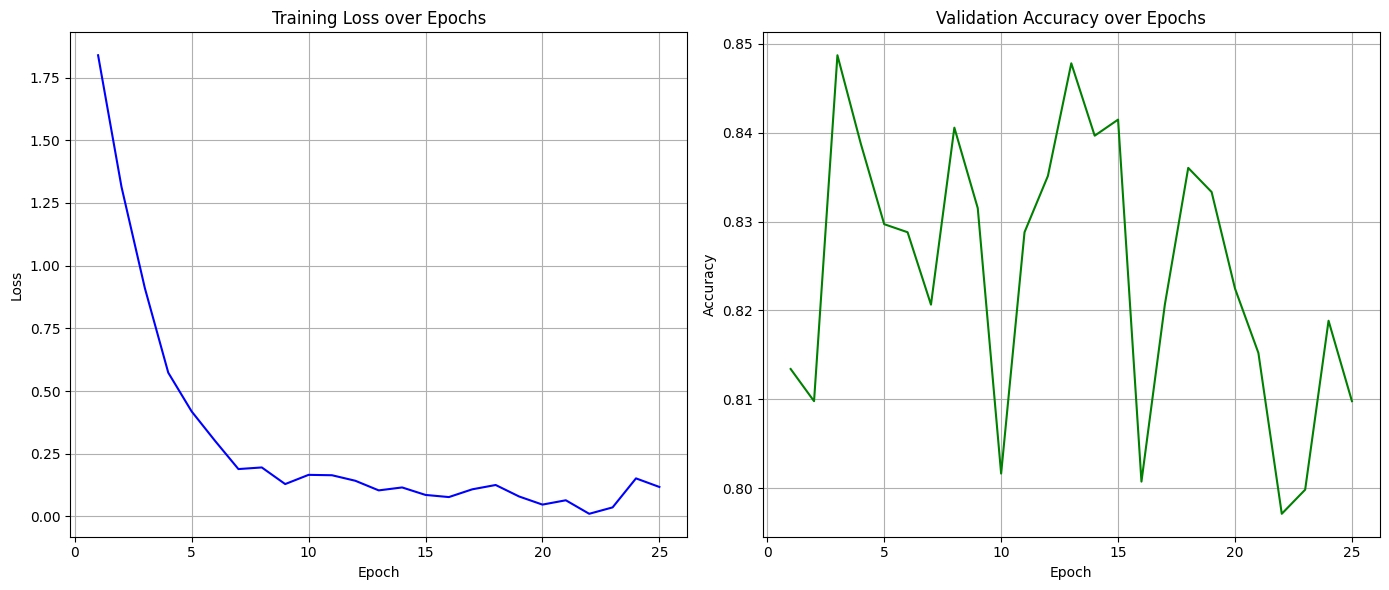

In [ ]:
!pip install timm

import torch
import torch.nn as nn
import torch.optim as optim
import timm
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define sentiment categories
sentiment_categories = ["Emotion Through Color", "Visual Complexity", "Movement and Flow", "Facial Expressions and Human Emotion"]

# Define ViT-based sentiment model with 4 custom heads
class SentimentModelWithViT(nn.Module):
    def __init__(self, backbone_name="vit_base_patch16_224", num_classes=4):
        super(SentimentModelWithViT, self).__init__()
        self.vit = timm.create_model(backbone_name, pretrained=True)

        # Extract the feature dimension from ViT head
        in_features = self.vit.head.in_features
        self.vit.head = nn.Identity()  # Remove the classification head

        # Four sentiment heads
        self.emotion_color_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.visual_complexity_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.movement_flow_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.human_emotion_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.vit(x)
        return (
            self.emotion_color_head(features),
            self.visual_complexity_head(features),
            self.movement_flow_head(features),
            self.human_emotion_head(features)
        )

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = SentimentModelWithViT().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

# Training settings
num_epochs = 25
start_time = time.time()
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            emotion_color, visual_complexity, movement_flow, human_emotion = vit_model(images)

            # Loss calculation
            loss1 = criterion(emotion_color.squeeze(), labels[:, 0])
            loss2 = criterion(visual_complexity.squeeze(), labels[:, 1])
            loss3 = criterion(movement_flow.squeeze(), labels[:, 2])
            loss4 = criterion(human_emotion.squeeze(), labels[:, 3])
            total_loss = loss1 + loss2 + loss3 + loss4
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

            # Accuracy calculation
            predictions = torch.cat([
                torch.sigmoid(emotion_color),
                torch.sigmoid(visual_complexity),
                torch.sigmoid(movement_flow),
                torch.sigmoid(human_emotion)
            ], dim=1)

            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)

            tepoch.set_postfix(loss=total_loss.item())

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")
    train_accuracy = correct_train / total_train if total_train > 0 else 0
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_losses.append(running_loss / len(train_loader))

    # Validation
    vit_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            emotion_color, visual_complexity, movement_flow, human_emotion = vit_model(images)

            pred1 = torch.sigmoid(emotion_color)
            pred2 = torch.sigmoid(visual_complexity)
            pred3 = torch.sigmoid(movement_flow)
            pred4 = torch.sigmoid(human_emotion)

            correct_val += (pred1 > 0.5).float().eq(labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (pred2 > 0.5).float().eq(labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (pred3 > 0.5).float().eq(labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (pred4 > 0.5).float().eq(labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4

    val_accuracy = correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Training complete
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time / 60:.2f} minutes)")

# Plotting
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


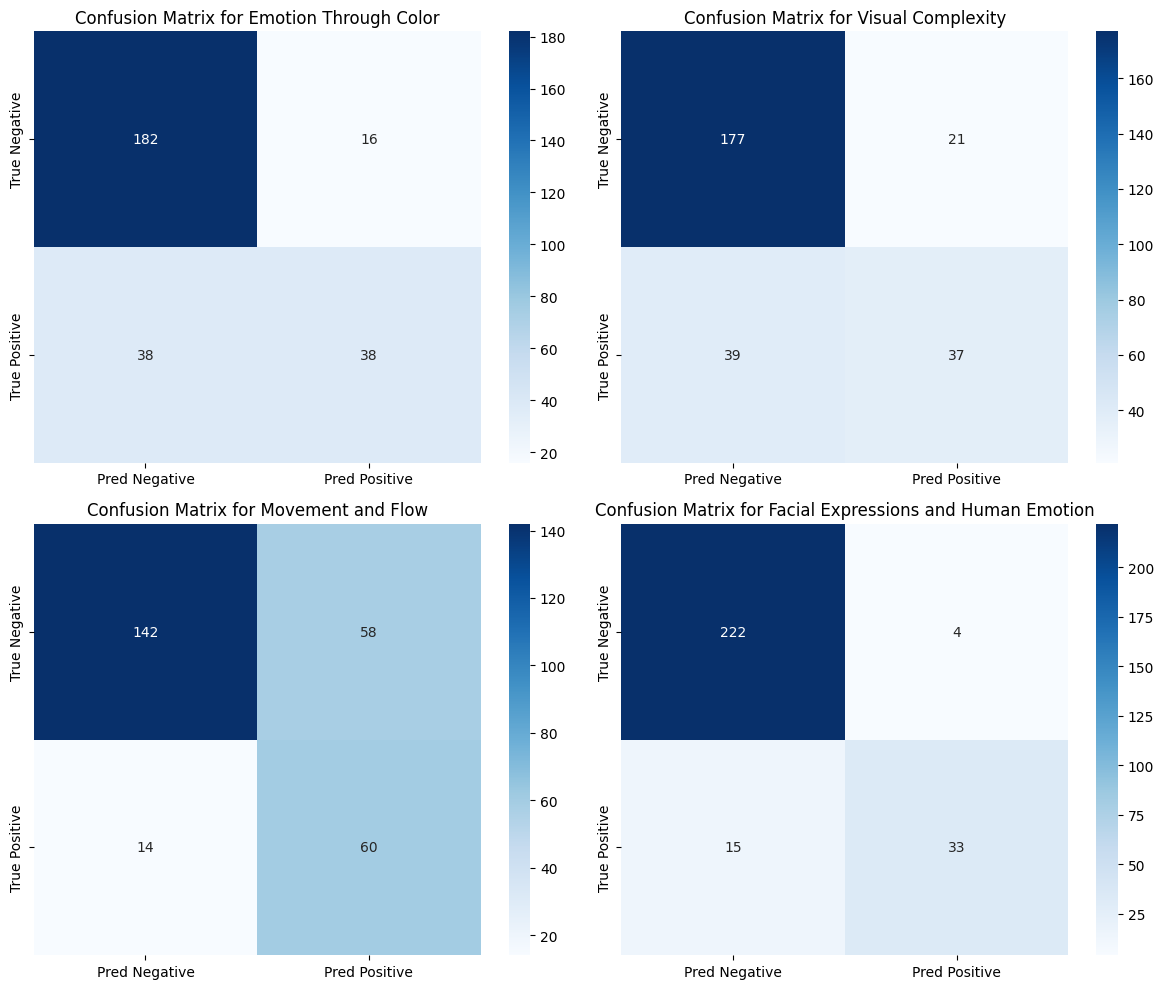

Test Accuracy: 81.30%
Precision: 60.95%
Recall: 61.31%
F1-Score: 61.07%


In [ ]:
# Define sentiment categories
sentiment_categories = ["Emotion Through Color", "Visual Complexity", "Movement and Flow", "Facial Expressions and Human Emotion"]

# Set the model to evaluation mode
vit_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        emotion_color, visual_complexity, movement_flow, human_emotion = vit_model(images)

        # Convert logits to probabilities using sigmoid
        pred_emotion_color = torch.sigmoid(emotion_color)
        pred_visual_complexity = torch.sigmoid(visual_complexity)
        pred_movement_flow = torch.sigmoid(movement_flow)
        pred_human_emotion = torch.sigmoid(human_emotion)

        # Binarize predictions (thresholding at 0.5)
        bin_emotion_color = (pred_emotion_color > 0.5).float()
        bin_visual_complexity = (pred_visual_complexity > 0.5).float()
        bin_movement_flow = (pred_movement_flow > 0.5).float()
        bin_human_emotion = (pred_human_emotion > 0.5).float()

        # Concatenate predictions for multi-label output
        batch_preds = torch.cat([bin_emotion_color, bin_visual_complexity, bin_movement_flow, bin_human_emotion], dim=1)
        all_predictions.append(batch_preds)
        all_labels.append(labels)

# Convert to NumPy arrays
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Compute evaluation metrics
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Multi-label confusion matrices
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'],
                ax=ax)
    ax.set_title(f'Confusion Matrix for {sentiment_categories[i]}')

plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


Epoch 1/25 Training: 100%|██████████| 86/86 [00:36<00:00,  2.38batch/s, loss=1.75]


Epoch 1 completed in 36.10 seconds.
Epoch Loss: 1.9681320232014323
Train Accuracy: 77.42%


Validation Accuracy: 84.15%


Epoch 2/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.49batch/s, loss=0.389]


Epoch 2 completed in 34.56 seconds.
Epoch Loss: 0.972309413344361
Train Accuracy: 90.13%


Validation Accuracy: 85.05%


Epoch 3/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.48batch/s, loss=0.346]


Epoch 3 completed in 34.72 seconds.
Epoch Loss: 0.457967100101848
Train Accuracy: 95.61%


Validation Accuracy: 88.13%


Epoch 4/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.49batch/s, loss=0.0607]


Epoch 4 completed in 34.50 seconds.
Epoch Loss: 0.21370306922945864
Train Accuracy: 98.23%


Validation Accuracy: 85.87%


Epoch 5/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.49batch/s, loss=0.452]


Epoch 5 completed in 34.55 seconds.
Epoch Loss: 0.10875652392589769
Train Accuracy: 99.35%


Validation Accuracy: 89.04%


Epoch 6/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.50batch/s, loss=0.666]


Epoch 6 completed in 34.46 seconds.
Epoch Loss: 0.09154458964503435
Train Accuracy: 99.38%


Validation Accuracy: 87.68%


Epoch 7/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.49batch/s, loss=0.057]


Epoch 7 completed in 34.59 seconds.
Epoch Loss: 0.08471405249478858
Train Accuracy: 99.31%


Validation Accuracy: 87.77%


Epoch 8/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.50batch/s, loss=0.0221]


Epoch 8 completed in 34.39 seconds.
Epoch Loss: 0.050903929746709764
Train Accuracy: 99.59%


Validation Accuracy: 88.77%


Epoch 9/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.50batch/s, loss=0.0083]


Epoch 9 completed in 34.36 seconds.
Epoch Loss: 0.03657211118031207
Train Accuracy: 99.72%


Validation Accuracy: 87.50%


Epoch 10/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.49batch/s, loss=0.0721]


Epoch 10 completed in 34.50 seconds.
Epoch Loss: 0.029740446340563425
Train Accuracy: 99.76%


Validation Accuracy: 87.14%


Epoch 11/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.52batch/s, loss=0.0437]


Epoch 11 completed in 34.09 seconds.
Epoch Loss: 0.06191791856098314
Train Accuracy: 99.51%


Validation Accuracy: 87.77%


Epoch 12/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.52batch/s, loss=0.0295]


Epoch 12 completed in 34.20 seconds.
Epoch Loss: 0.04901291206641512
Train Accuracy: 99.60%


Validation Accuracy: 88.22%


Epoch 13/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.51batch/s, loss=0.0364]


Epoch 13 completed in 34.24 seconds.
Epoch Loss: 0.06029234976821774
Train Accuracy: 99.50%


Validation Accuracy: 89.22%


Epoch 14/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.49batch/s, loss=0.00677]


Epoch 14 completed in 34.48 seconds.
Epoch Loss: 0.045763988195387864
Train Accuracy: 99.66%


Validation Accuracy: 88.95%


Epoch 15/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.50batch/s, loss=0.504]


Epoch 15 completed in 34.42 seconds.
Epoch Loss: 0.029950351144327935
Train Accuracy: 99.80%


Validation Accuracy: 88.59%


Epoch 16/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.47batch/s, loss=0.149]


Epoch 16 completed in 34.76 seconds.
Epoch Loss: 0.039004909095278574
Train Accuracy: 99.67%


Validation Accuracy: 89.31%


Epoch 17/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.49batch/s, loss=0.0719]


Epoch 17 completed in 34.48 seconds.
Epoch Loss: 0.05361929666629971
Train Accuracy: 99.50%


Validation Accuracy: 89.04%


Epoch 18/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.47batch/s, loss=0.00405]


Epoch 18 completed in 34.76 seconds.
Epoch Loss: 0.03544359021349052
Train Accuracy: 99.76%


Validation Accuracy: 88.95%


Epoch 19/25 Training: 100%|██████████| 86/86 [00:35<00:00,  2.44batch/s, loss=0.0478]


Epoch 19 completed in 35.20 seconds.
Epoch Loss: 0.05511902129686394
Train Accuracy: 99.53%


Validation Accuracy: 88.04%


Epoch 20/25 Training: 100%|██████████| 86/86 [00:35<00:00,  2.45batch/s, loss=1.25]


Epoch 20 completed in 35.11 seconds.
Epoch Loss: 0.055132769983597535
Train Accuracy: 99.66%


Validation Accuracy: 88.86%


Epoch 21/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.46batch/s, loss=0.0561]


Epoch 21 completed in 34.98 seconds.
Epoch Loss: 0.03635876262858293
Train Accuracy: 99.77%


Validation Accuracy: 89.86%


Epoch 22/25 Training: 100%|██████████| 86/86 [00:35<00:00,  2.45batch/s, loss=0.00176]


Epoch 22 completed in 35.10 seconds.
Epoch Loss: 0.037010762349128465
Train Accuracy: 99.70%


Validation Accuracy: 89.13%


Epoch 23/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.46batch/s, loss=0.0684]


Epoch 23 completed in 34.93 seconds.
Epoch Loss: 0.03502748690161118
Train Accuracy: 99.74%


Validation Accuracy: 88.22%


Epoch 24/25 Training: 100%|██████████| 86/86 [00:34<00:00,  2.46batch/s, loss=0.0567]


Epoch 24 completed in 34.91 seconds.
Epoch Loss: 0.030226933461245754
Train Accuracy: 99.74%


Validation Accuracy: 89.13%


Epoch 25/25 Training: 100%|██████████| 86/86 [00:35<00:00,  2.45batch/s, loss=0.115]


Epoch 25 completed in 35.05 seconds.
Epoch Loss: 0.04199859480235488
Train Accuracy: 99.68%


Validation Accuracy: 89.04%

Total Training Time: 904.65 seconds (15.08 minutes)


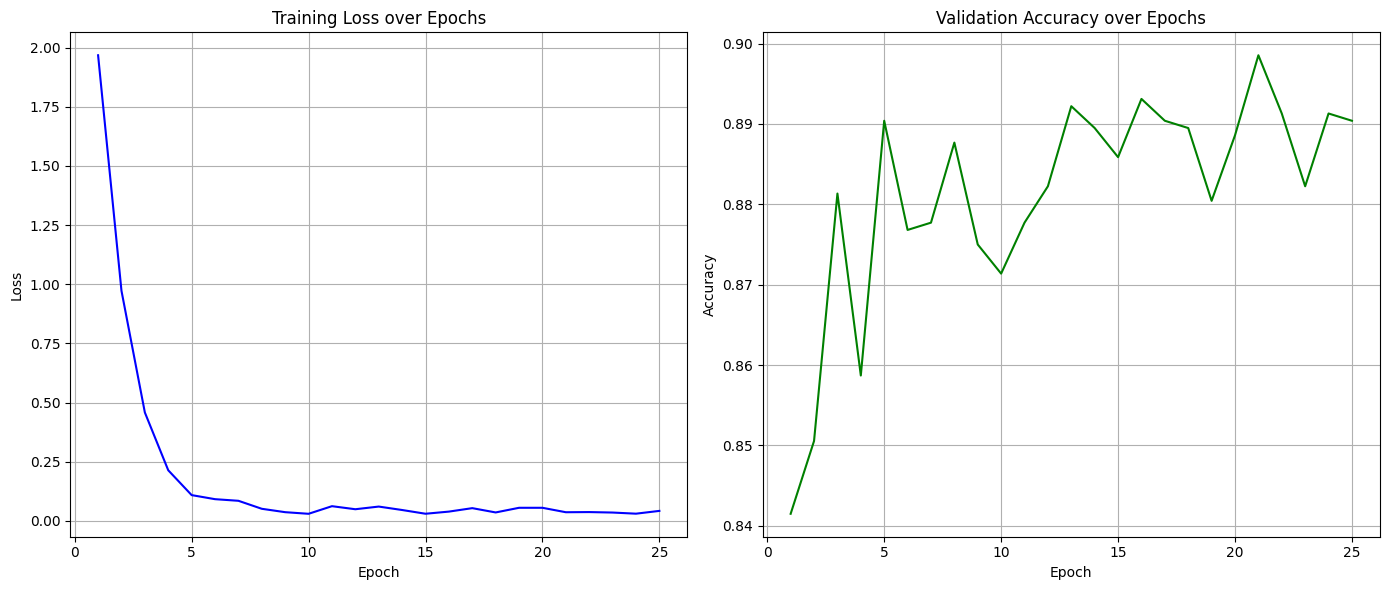

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define sentiment categories
sentiment_categories = ["Emotion Through Color", "Visual Complexity", "Movement and Flow", "Facial Expressions and Human Emotion"]

# Define model based on EfficientNet with custom heads for the 4 sentiment classes
class SentimentModelWithEfficientNet(nn.Module):
    def __init__(self, backbone_name="efficientnet_b0", num_classes=4):
        super(SentimentModelWithEfficientNet, self).__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True)
        in_features = self.backbone.classifier.in_features  # Get input size of the head
        self.backbone.classifier = nn.Identity()  # Remove the classification layer

        # Four custom heads for each sentiment dimension
        self.emotion_color_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.visual_complexity_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.movement_flow_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.human_emotion_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.backbone(x)
        return (
            self.emotion_color_head(features),
            self.visual_complexity_head(features),
            self.movement_flow_head(features),
            self.human_emotion_head(features)
        )

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
effnet_model = SentimentModelWithEfficientNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(effnet_model.parameters(), lr=1e-4)

# Training setup
num_epochs = 25
start_time = time.time()
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    effnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            ec, vc, mf, he = effnet_model(images)

            loss1 = criterion(ec.squeeze(), labels[:, 0])
            loss2 = criterion(vc.squeeze(), labels[:, 1])
            loss3 = criterion(mf.squeeze(), labels[:, 2])
            loss4 = criterion(he.squeeze(), labels[:, 3])
            total_loss = loss1 + loss2 + loss3 + loss4

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

            predictions = torch.cat([
                torch.sigmoid(ec),
                torch.sigmoid(vc),
                torch.sigmoid(mf),
                torch.sigmoid(he)
            ], dim=1)

            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)

            tepoch.set_postfix(loss=total_loss.item())

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")
    train_accuracy = correct_train / total_train
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_losses.append(running_loss / len(train_loader))

    # Validation
    effnet_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            ec, vc, mf, he = effnet_model(images)

            pred1 = torch.sigmoid(ec)
            pred2 = torch.sigmoid(vc)
            pred3 = torch.sigmoid(mf)
            pred4 = torch.sigmoid(he)

            correct_val += (pred1 > 0.5).float().eq(labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (pred2 > 0.5).float().eq(labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (pred3 > 0.5).float().eq(labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (pred4 > 0.5).float().eq(labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4

    val_accuracy = correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Training complete
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time / 60:.2f} minutes)")

# Plotting
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


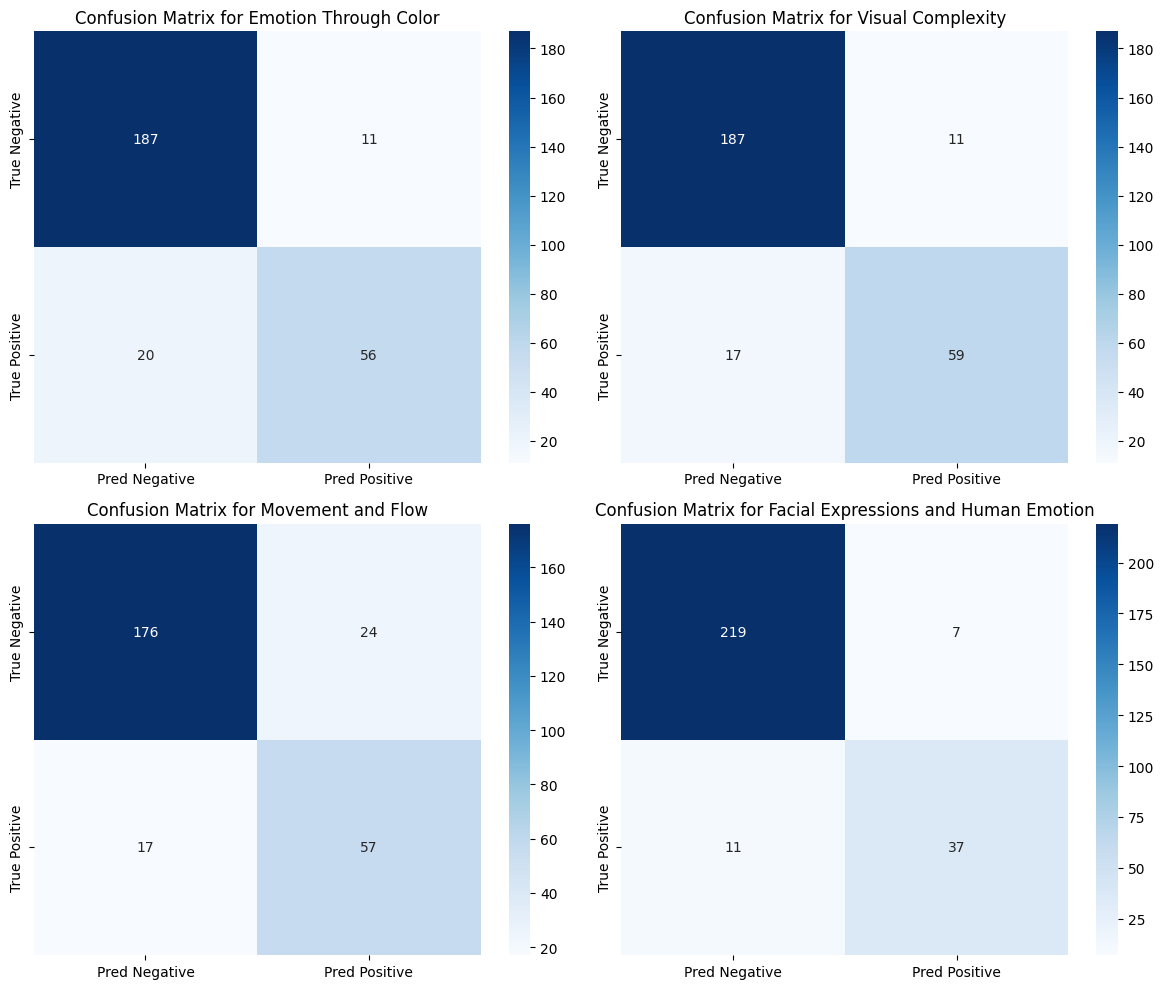

Test Accuracy: 89.23%
Precision: 75.73%
Recall: 76.28%
F1-Score: 75.91%


In [7]:
# Define sentiment categories
sentiment_categories = ["Emotion Through Color", "Visual Complexity", "Movement and Flow", "Facial Expressions and Human Emotion"]

# Set the model to evaluation mode
effnet_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        emotion_color, visual_complexity, movement_flow, human_emotion = effnet_model(images)

        # Convert logits to probabilities using sigmoid
        pred_emotion_color = torch.sigmoid(emotion_color)
        pred_visual_complexity = torch.sigmoid(visual_complexity)
        pred_movement_flow = torch.sigmoid(movement_flow)
        pred_human_emotion = torch.sigmoid(human_emotion)

        # Binarize predictions (thresholding at 0.5)
        bin_emotion_color = (pred_emotion_color > 0.5).float()
        bin_visual_complexity = (pred_visual_complexity > 0.5).float()
        bin_movement_flow = (pred_movement_flow > 0.5).float()
        bin_human_emotion = (pred_human_emotion > 0.5).float()

        # Concatenate predictions for multi-label output
        batch_preds = torch.cat([bin_emotion_color, bin_visual_complexity, bin_movement_flow, bin_human_emotion], dim=1)
        all_predictions.append(batch_preds)
        all_labels.append(labels)

# Convert to NumPy arrays
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Compute evaluation metrics
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Multi-label confusion matrices
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'],
                ax=ax)
    ax.set_title(f'Confusion Matrix for {sentiment_categories[i]}')

plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


In [8]:
import torch

# Assuming you have a model defined as `model`
# Example:
# model = AestheticModel()  # Replace with your actual model definition

# Convert the model to TorchScript (this assumes the model's forward function is compatible)
scripted_model = torch.jit.script(effnet_model)  # Convert to TorchScript

# Save the TorchScript model to a file
torch.jit.save(scripted_model, "/content/sentiment_effnet_model.pth")

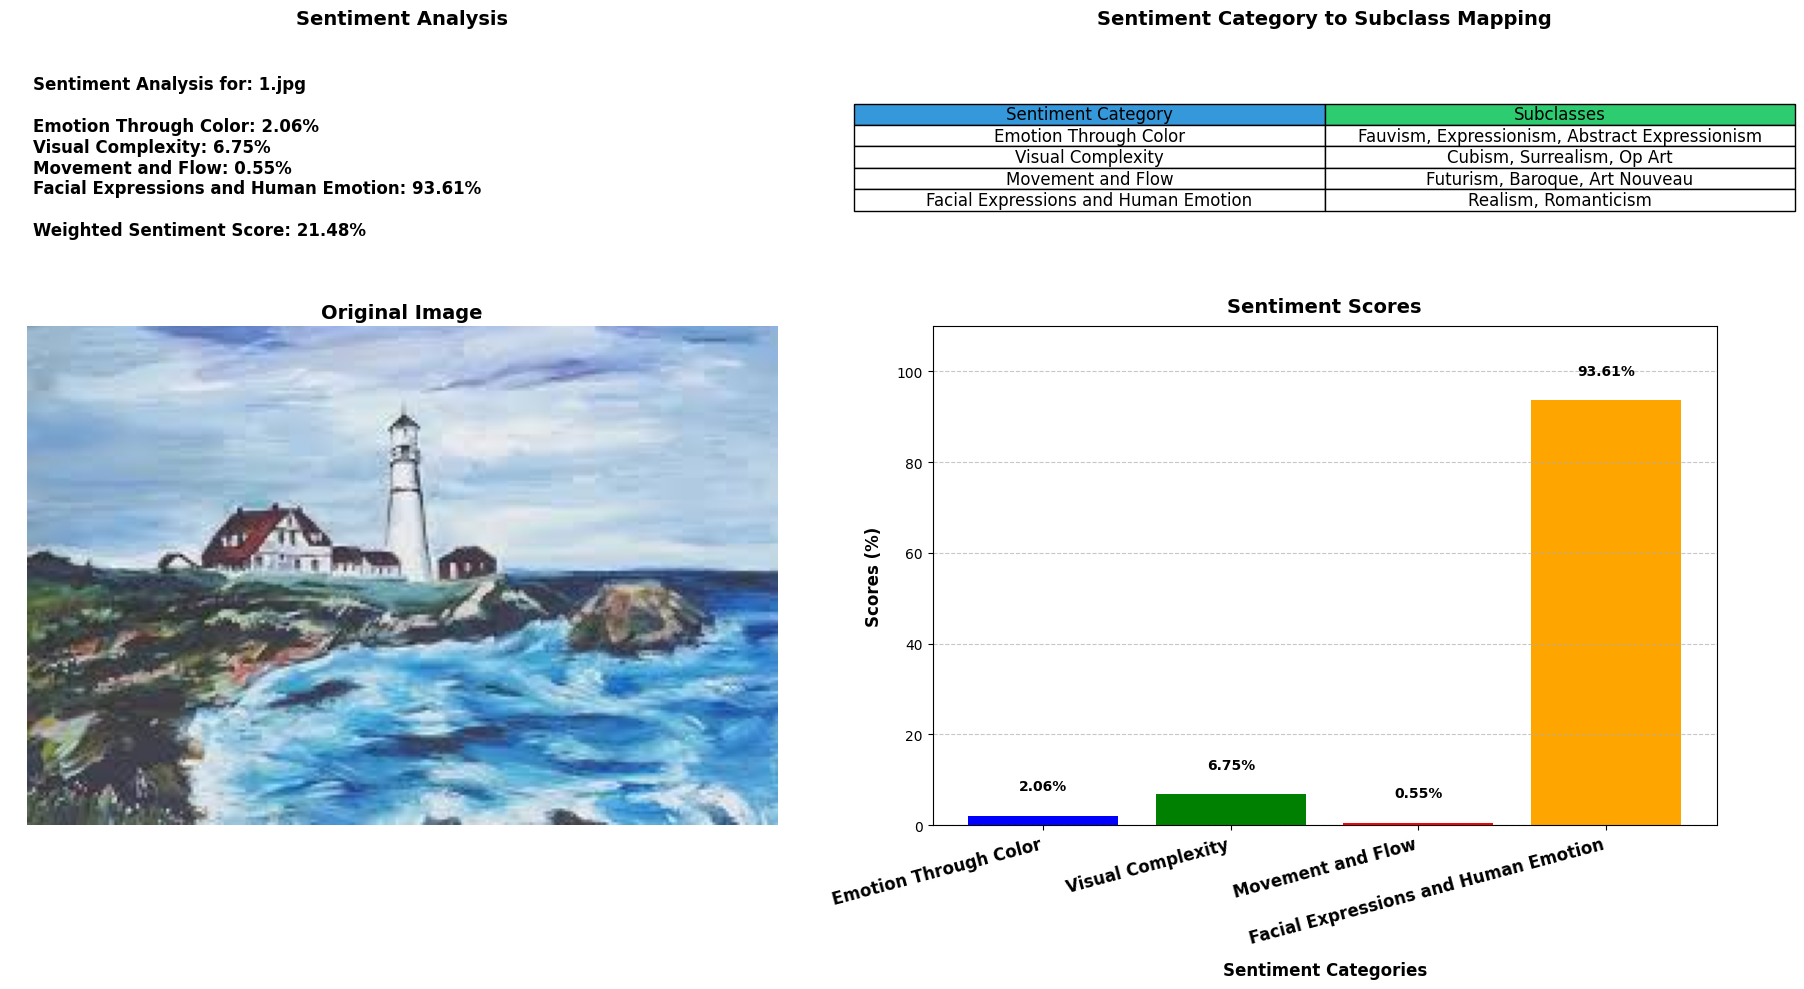

In [9]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
from PIL import Image

# Load TorchScript sentiment model
scripted_model = torch.jit.load("/content/CSE499-MerakiNexus-AI_And_Defi/sentiment_model/models/sentiment_effnet_model.pth")
scripted_model.eval()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scripted_model.to(device)

# Define sentiment categories and weights
sentiment_categories = [
    "Emotion Through Color",
    "Visual Complexity",
    "Movement and Flow",
    "Facial Expressions and Human Emotion"
]

weights = {
    "Emotion Through Color": 0.3,
    "Visual Complexity": 0.3,
    "Movement and Flow": 0.2,
    "Facial Expressions and Human Emotion": 0.2
}

category_to_subclasses = {
    "Emotion Through Color": ["Fauvism", "Expressionism", "Abstract Expressionism"],
    "Visual Complexity": ["Cubism", "Surrealism", "Op Art"],
    "Movement and Flow": ["Futurism", "Baroque", "Art Nouveau"],
    "Facial Expressions and Human Emotion": ["Realism", "Romanticism"]
}

# Image preprocessing
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

# Inference
def run_inference(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        outputs = scripted_model(image_tensor)
        e_color, v_complexity, movement, emotion = outputs

        scores = {
            "Emotion Through Color": torch.sigmoid(e_color).item() * 100,
            "Visual Complexity": torch.sigmoid(v_complexity).item() * 100,
            "Movement and Flow": torch.sigmoid(movement).item() * 100,
            "Facial Expressions and Human Emotion": torch.sigmoid(emotion).item() * 100
        }
    return scores

# Visualization
def visualize_sentiment_scores(image_path):
    scores = run_inference(image_path)
    weighted_score = sum(scores[k] * weights[k] for k in scores)

    mapping_df = pd.DataFrame(
        [(cat, ", ".join(subs)) for cat, subs in category_to_subclasses.items()],
        columns=["Sentiment Category", "Subclasses"]
    )

    fig, axes = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 2]})

    # Text summary
    summary = f"""
    Sentiment Analysis for: {image_path}

    Emotion Through Color: {scores['Emotion Through Color']:.2f}%
    Visual Complexity: {scores['Visual Complexity']:.2f}%
    Movement and Flow: {scores['Movement and Flow']:.2f}%
    Facial Expressions and Human Emotion: {scores['Facial Expressions and Human Emotion']:.2f}%

    Weighted Sentiment Score: {weighted_score:.2f}%
    """
    axes[0, 0].text(0, 0.5, summary, fontsize=12, fontweight="bold", va='center', ha='left')
    axes[0, 0].axis("off")
    axes[0, 0].set_title("Sentiment Analysis", fontsize=14, fontweight="bold")

    # Category mapping table
    axes[0, 1].axis("tight")
    axes[0, 1].axis("off")
    table = axes[0, 1].table(
        cellText=mapping_df.values,
        colLabels=mapping_df.columns,
        cellLoc="center",
        loc="center",
        colColours=["#3498db", "#2ecc71"]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    axes[0, 1].set_title("Sentiment Category to Subclass Mapping", fontsize=14, fontweight="bold")

    # Original image
    image = Image.open(image_path)
    axes[1, 0].imshow(image)
    axes[1, 0].axis("off")
    axes[1, 0].set_title("Original Image", fontsize=14, fontweight='bold')

    # Bar chart
    bars = axes[1, 1].bar(scores.keys(), scores.values(), color=['blue', 'green', 'red', 'orange'])
    for bar in bars:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2,
                        bar.get_height() + 5,
                        f'{bar.get_height():.2f}%',
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    axes[1, 1].set_xticks(range(len(scores)))
    axes[1, 1].set_xticklabels(scores.keys(), fontsize=12, fontweight='bold', rotation=15, ha='right')
    axes[1, 1].set_xlabel('Sentiment Categories', fontsize=12, fontweight='bold', labelpad=10)
    axes[1, 1].set_ylabel('Scores (%)', fontsize=12, fontweight='bold', labelpad=10)
    axes[1, 1].set_title('Sentiment Scores', fontsize=14, fontweight='bold', pad=10)
    axes[1, 1].set_ylim(0, 110)
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Example usage
image_path = "1.jpg"  # Replace with your test image
visualize_sentiment_scores(image_path)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 157MB/s]
Epoch 1/25 Training: 100%|██████████| 86/86 [00:28<00:00,  3.05batch/s, loss=1.15]


Epoch 1 completed in 28.19 seconds.
Epoch Loss: 1.5795463808747225
Train Accuracy: 81.09%


Validation Accuracy: 83.51%


Epoch 2/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.23batch/s, loss=0.631]


Epoch 2 completed in 26.60 seconds.
Epoch Loss: 0.9746742504973744
Train Accuracy: 89.36%


Validation Accuracy: 84.06%


Epoch 3/25 Training: 100%|██████████| 86/86 [00:27<00:00,  3.12batch/s, loss=0.576]


Epoch 3 completed in 27.56 seconds.
Epoch Loss: 0.5936083232247552
Train Accuracy: 94.07%


Validation Accuracy: 88.50%


Epoch 4/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.27batch/s, loss=0.297]


Epoch 4 completed in 26.27 seconds.
Epoch Loss: 0.34476412512188737
Train Accuracy: 96.60%


Validation Accuracy: 87.41%


Epoch 5/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.27batch/s, loss=0.402]


Epoch 5 completed in 26.29 seconds.
Epoch Loss: 0.24898986765291803
Train Accuracy: 97.67%


Validation Accuracy: 86.23%


Epoch 6/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.27batch/s, loss=0.209]


Epoch 6 completed in 26.32 seconds.
Epoch Loss: 0.12425221347921463
Train Accuracy: 98.95%


Validation Accuracy: 82.25%


Epoch 7/25 Training: 100%|██████████| 86/86 [00:28<00:00,  3.04batch/s, loss=0.0624]


Epoch 7 completed in 28.32 seconds.
Epoch Loss: 0.14651067000218168
Train Accuracy: 98.63%


Validation Accuracy: 87.77%


Epoch 8/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.26batch/s, loss=0.0443]


Epoch 8 completed in 26.39 seconds.
Epoch Loss: 0.09051593622939964
Train Accuracy: 99.15%


Validation Accuracy: 86.87%


Epoch 9/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.27batch/s, loss=0.000914]


Epoch 9 completed in 26.29 seconds.
Epoch Loss: 0.10260248992343021
Train Accuracy: 99.21%


Validation Accuracy: 86.41%


Epoch 10/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.20batch/s, loss=0.00615]


Epoch 10 completed in 26.91 seconds.
Epoch Loss: 0.07778889304676721
Train Accuracy: 99.24%


Validation Accuracy: 85.42%


Epoch 11/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.25batch/s, loss=0.504]


Epoch 11 completed in 26.45 seconds.
Epoch Loss: 0.11055254491674173
Train Accuracy: 99.02%


Validation Accuracy: 86.05%


Epoch 12/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.26batch/s, loss=0.0413]


Epoch 12 completed in 26.35 seconds.
Epoch Loss: 0.1555709233669954
Train Accuracy: 98.63%


Validation Accuracy: 86.87%


Epoch 13/25 Training: 100%|██████████| 86/86 [00:27<00:00,  3.18batch/s, loss=0.288]


Epoch 13 completed in 27.04 seconds.
Epoch Loss: 0.040786982476061516
Train Accuracy: 99.68%


Validation Accuracy: 86.59%


Epoch 14/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.28batch/s, loss=0.0251]


Epoch 14 completed in 26.23 seconds.
Epoch Loss: 0.1282460761938764
Train Accuracy: 98.80%


Validation Accuracy: 87.32%


Epoch 15/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.29batch/s, loss=0.122]


Epoch 15 completed in 26.18 seconds.
Epoch Loss: 0.03995232261395147
Train Accuracy: 99.73%


Validation Accuracy: 86.32%


Epoch 16/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.26batch/s, loss=0.024]


Epoch 16 completed in 26.39 seconds.
Epoch Loss: 0.028321700942902935
Train Accuracy: 99.77%


Validation Accuracy: 87.05%


Epoch 17/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.20batch/s, loss=0.0189]


Epoch 17 completed in 26.89 seconds.
Epoch Loss: 0.03215767899433389
Train Accuracy: 99.70%


Validation Accuracy: 85.60%


Epoch 18/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.20batch/s, loss=0.00675]


Epoch 18 completed in 26.91 seconds.
Epoch Loss: 0.02802252277530876
Train Accuracy: 99.73%


Validation Accuracy: 86.05%


Epoch 19/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.28batch/s, loss=0.0134]


Epoch 19 completed in 26.20 seconds.
Epoch Loss: 0.14904033946317383
Train Accuracy: 98.74%


Validation Accuracy: 86.05%


Epoch 20/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.27batch/s, loss=0.124]


Epoch 20 completed in 26.32 seconds.
Epoch Loss: 0.07550021286561089
Train Accuracy: 99.31%


Validation Accuracy: 87.05%


Epoch 21/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.26batch/s, loss=0.00301]


Epoch 21 completed in 26.36 seconds.
Epoch Loss: 0.051508120331523376
Train Accuracy: 99.51%


Validation Accuracy: 87.95%


Epoch 22/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.27batch/s, loss=0.0282]


Epoch 22 completed in 26.31 seconds.
Epoch Loss: 0.03356324131942359
Train Accuracy: 99.73%


Validation Accuracy: 86.68%


Epoch 23/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.26batch/s, loss=0.392]


Epoch 23 completed in 26.36 seconds.
Epoch Loss: 0.06457166673346872
Train Accuracy: 99.50%


Validation Accuracy: 84.15%


Epoch 24/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.21batch/s, loss=0.00296]


Epoch 24 completed in 26.77 seconds.
Epoch Loss: 0.059312017612852326
Train Accuracy: 99.49%


Validation Accuracy: 86.50%


Epoch 25/25 Training: 100%|██████████| 86/86 [00:26<00:00,  3.26batch/s, loss=0.0243]


Epoch 25 completed in 26.41 seconds.
Epoch Loss: 0.02609431353309002
Train Accuracy: 99.79%


Validation Accuracy: 86.05%

Total Training Time: 698.23 seconds (11.64 minutes)


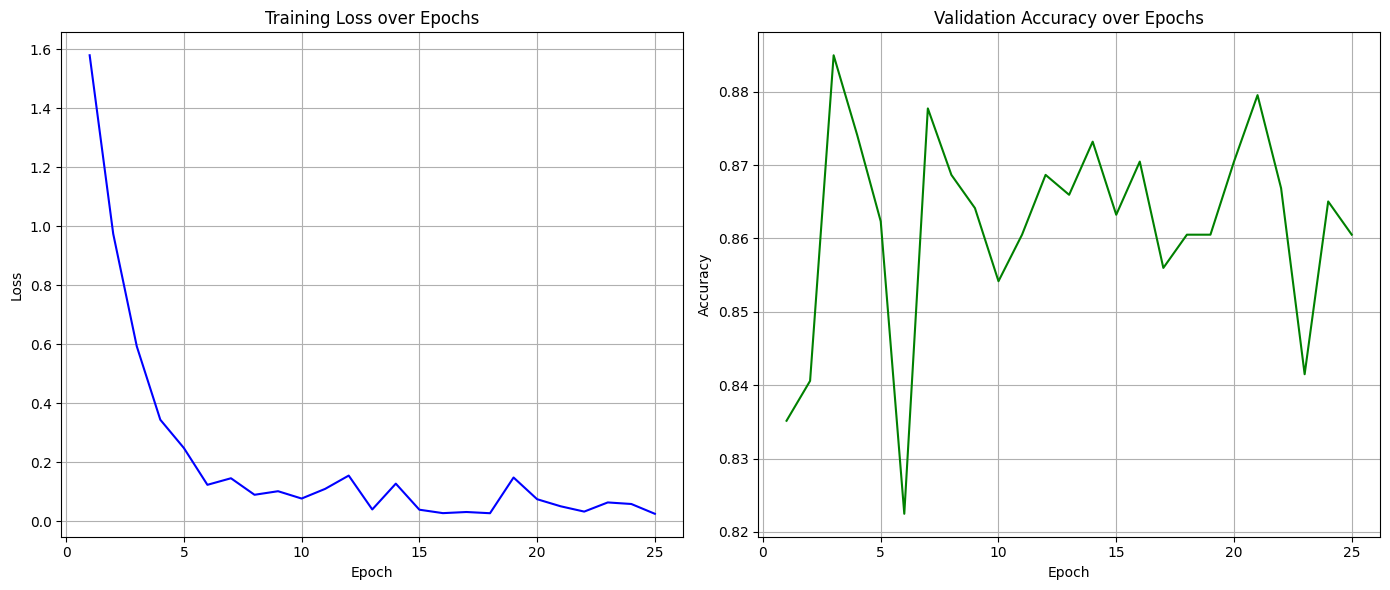

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define sentiment categories
sentiment_categories = ["Emotion Through Color", "Visual Complexity", "Movement and Flow", "Facial Expressions and Human Emotion"]

# Define AlexNet-based model with 4 custom heads
class SentimentModelWithAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SentimentModelWithAlexNet, self).__init__()
        self.backbone = models.alexnet(pretrained=True)
        in_features = self.backbone.classifier[6].in_features

        # Remove the original classification head
        self.backbone.classifier[6] = nn.Identity()

        # Define 4 separate heads for each sentiment category
        self.emotion_color_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.visual_complexity_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.movement_flow_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.human_emotion_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.backbone(x)
        return (
            self.emotion_color_head(features),
            self.visual_complexity_head(features),
            self.movement_flow_head(features),
            self.human_emotion_head(features)
        )

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alexnet_model = SentimentModelWithAlexNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=1e-4)

# Training setup
num_epochs = 25
start_time = time.time()
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    alexnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            ec, vc, mf, he = alexnet_model(images)

            loss1 = criterion(ec.squeeze(), labels[:, 0])
            loss2 = criterion(vc.squeeze(), labels[:, 1])
            loss3 = criterion(mf.squeeze(), labels[:, 2])
            loss4 = criterion(he.squeeze(), labels[:, 3])
            total_loss = loss1 + loss2 + loss3 + loss4

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

            predictions = torch.cat([
                torch.sigmoid(ec),
                torch.sigmoid(vc),
                torch.sigmoid(mf),
                torch.sigmoid(he)
            ], dim=1)

            predicted_labels = (predictions > 0.5).float()
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)

            tepoch.set_postfix(loss=total_loss.item())

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")
    train_accuracy = correct_train / total_train
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    alexnet_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            ec, vc, mf, he = alexnet_model(images)

            pred1 = torch.sigmoid(ec)
            pred2 = torch.sigmoid(vc)
            pred3 = torch.sigmoid(mf)
            pred4 = torch.sigmoid(he)

            correct_val += (pred1 > 0.5).float().eq(labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (pred2 > 0.5).float().eq(labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (pred3 > 0.5).float().eq(labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (pred4 > 0.5).float().eq(labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4

    val_accuracy = correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Final stats
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time / 60:.2f} minutes)")

# Plotting loss and accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


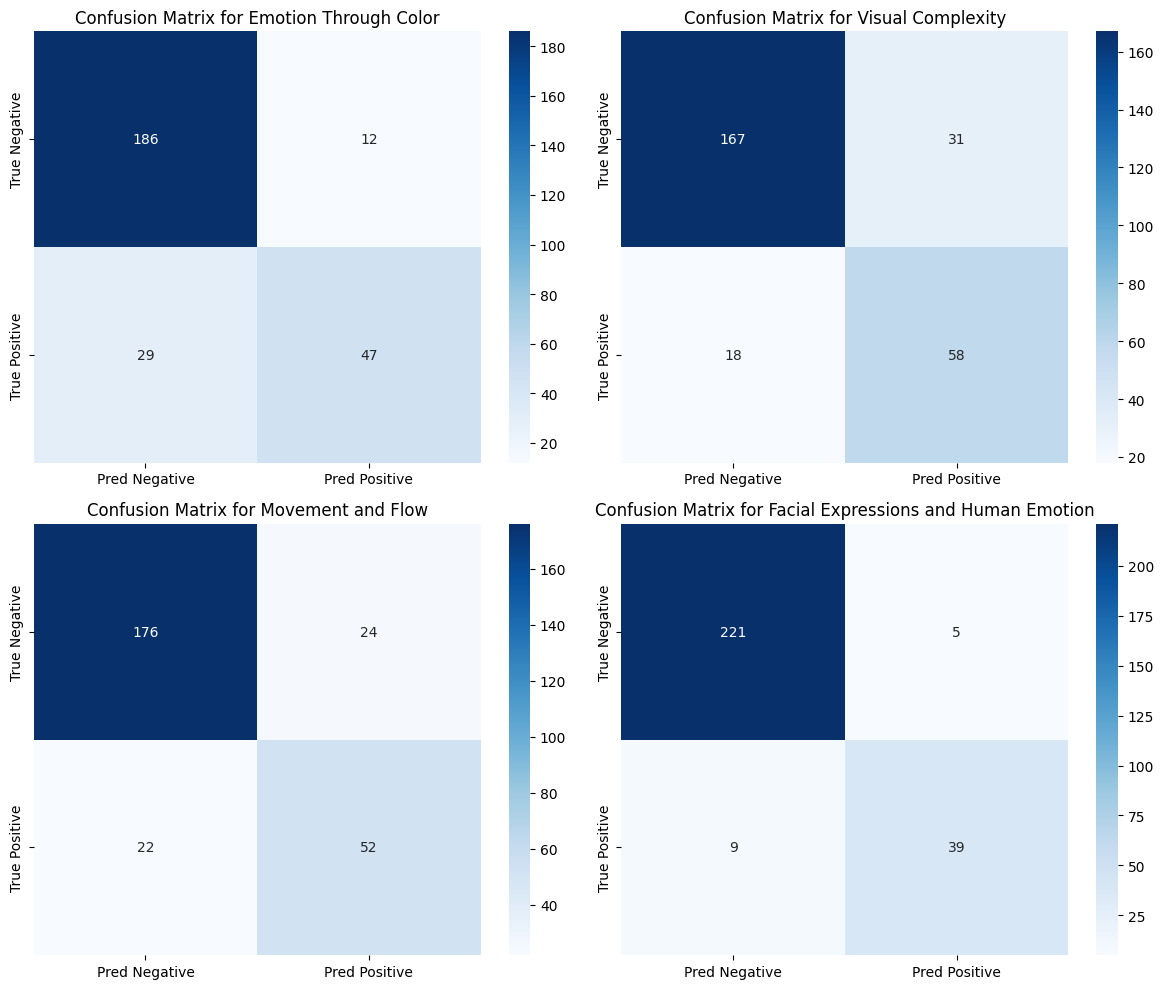

Test Accuracy: 86.31%
Precision: 70.80%
Recall: 71.53%
F1-Score: 71.05%


In [ ]:
# Define sentiment categories
sentiment_categories = ["Emotion Through Color", "Visual Complexity", "Movement and Flow", "Facial Expressions and Human Emotion"]

# Set the model to evaluation mode
alexnet_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        emotion_color, visual_complexity, movement_flow, human_emotion = alexnet_model(images)

        # Convert logits to probabilities using sigmoid
        pred_emotion_color = torch.sigmoid(emotion_color)
        pred_visual_complexity = torch.sigmoid(visual_complexity)
        pred_movement_flow = torch.sigmoid(movement_flow)
        pred_human_emotion = torch.sigmoid(human_emotion)

        # Binarize predictions (thresholding at 0.5)
        bin_emotion_color = (pred_emotion_color > 0.5).float()
        bin_visual_complexity = (pred_visual_complexity > 0.5).float()
        bin_movement_flow = (pred_movement_flow > 0.5).float()
        bin_human_emotion = (pred_human_emotion > 0.5).float()

        # Concatenate predictions for multi-label output
        batch_preds = torch.cat([bin_emotion_color, bin_visual_complexity, bin_movement_flow, bin_human_emotion], dim=1)
        all_predictions.append(batch_preds)
        all_labels.append(labels)

# Convert to NumPy arrays
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Compute evaluation metrics
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Multi-label confusion matrices
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot confusion matrices for each class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'],
                ax=ax)
    ax.set_title(f'Confusion Matrix for {sentiment_categories[i]}')

plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
